## Forex model
These area theh intial model candidates:
1. Exponential smoothing
2. Markov switching
3. ARIMA
4. GBRT(XGBoost implementation)
5. LSTM(if others do not achieve a statisfactory R^2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
import xgboost
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import Holt
from datetime import datetime, timedelta

In [2]:
# Import data: the ports are mapped to 5454.

host = "localhost"
port = "5454"
db = "forex"
con = create_engine(f"postgresql://airflow:airflow@{host}:{port}/{db}")

In [3]:
ex_rates = pd.read_sql_query("SELECT * FROM ex_rates", con=con.connect().connection)
master = pd.read_sql_query("SELECT * FROM master", con=con.connect().connection)

/tmp/ipykernel_5295/2340188343.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ex_rates = pd.read_sql_query("SELECT * FROM ex_rates", con=con.connect().connection)
/tmp/ipykernel_5295/2340188343.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  master = pd.read_sql_query("SELECT * FROM master", con=con.connect().connection)


In [4]:
ex_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86223 entries, 0 to 86222
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   currency     86223 non-null  int64         
 1   time_period  86223 non-null  datetime64[ns]
 2   rate         86223 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.0 MB


In [5]:
# As mentioned in tsa.R, we have to remove BGN(Bulgarian lev), since it is pegged to euro, and it may mess up calculations
currency_codes = pd.read_sql_query("SELECT * FROM dim_currency", con=con.connect().connection)
currency_codes.head()

bgn_code = currency_codes[currency_codes['name'] == "BGN"]\
  ['ex_id'].values[0]

ex_rates = ex_rates[ex_rates['currency'] != bgn_code]

/tmp/ipykernel_5295/1397585027.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  currency_codes = pd.read_sql_query("SELECT * FROM dim_currency", con=con.connect().connection)


In [6]:
def prepare_ts(data):
  return data.set_index('time_period').asfreq('d').bfill()

In [7]:
def train_test_ts(data, tresh_date) -> tuple[pd.DataFrame] | None:
  train = prepare_ts(data[data['time_period'] < tresh_date])

  test = prepare_ts(data[data['time_period'] > tresh_date])

  if test.shape[0] == 0:
    return (None, None)
  
  return (train, test)

## Holt's smoothing

In [8]:
tresh_date = datetime(2024, 11, 1)
mask = ex_rates['time_period'] < tresh_date
df = ex_rates.groupby('currency')

preds = {}

for group, data in df:
  train, test = train_test_ts(data, tresh_date)

  if test is None:
    continue

  holt = Holt(train['rate']).fit()

  time_set = test.reset_index()['time_period']
  start, end = time_set.min(), time_set.max()

  pred = holt.predict(start=start, end=end)
  preds[group] = (pred, test['rate'])

In [9]:
from sklearn.metrics import r2_score

In [10]:
### Error analysis
for key, (pred, target) in preds.items():
  err = pred - target

  mae = np.mean(np.abs(err))
  rmse = np.sqrt(np.mean(err ** 2))
  r2 = r2_score(target, pred)

  print(f"On currency {key} model has R^2: {r2}")


On currency 1 model has R^2: -1.5875579339338008
On currency 3 model has R^2: -0.07406328078521263
On currency 4 model has R^2: -9.109449541814902
On currency 5 model has R^2: -0.6509488662374809
On currency 6 model has R^2: -1.7320788204752362
On currency 7 model has R^2: -5.521496093778821
On currency 8 model has R^2: -5.113345825320659
On currency 13 model has R^2: -0.5919584141587193
On currency 18 model has R^2: -4.131971098715355
On currency 20 model has R^2: 0.3907271526712588
On currency 21 model has R^2: -9.439736757437327
On currency 22 model has R^2: -3.9982829342858297
On currency 23 model has R^2: -6.902735770207775
On currency 24 model has R^2: -5.199927508528923
On currency 25 model has R^2: -30.753019518733907
On currency 26 model has R^2: -0.24867275669741695
On currency 28 model has R^2: -19.28249520837001
On currency 29 model has R^2: -0.8485882655022883
On currency 30 model has R^2: -21.302467660780575
On currency 31 model has R^2: -1.3966939422971074
On currency 32

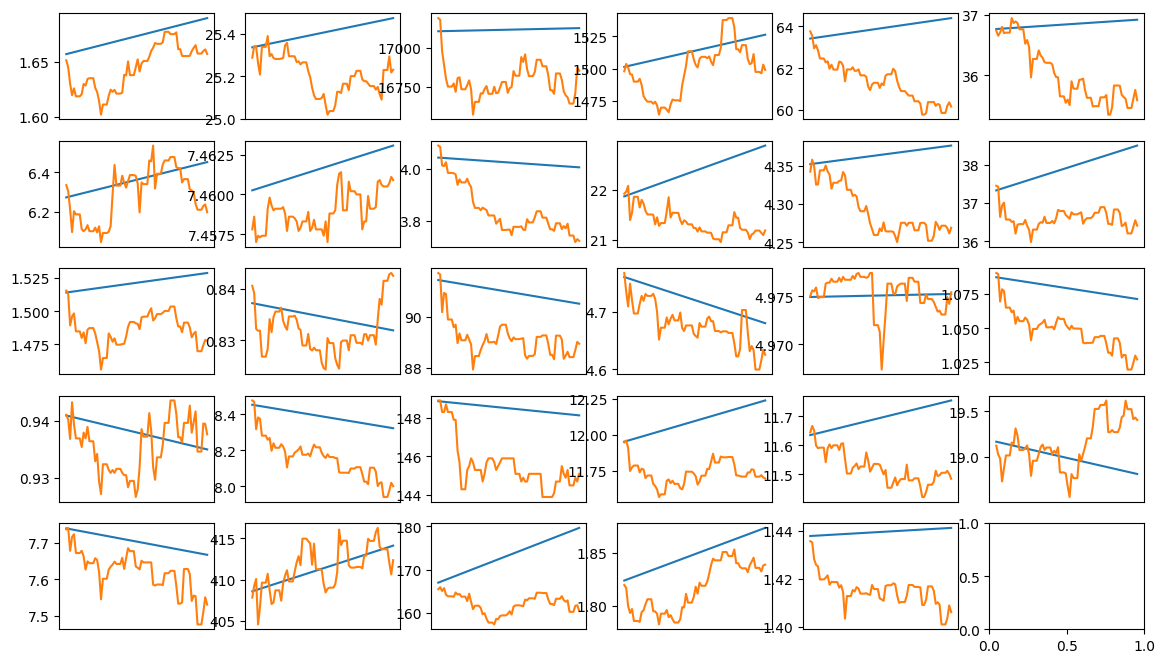

In [11]:
fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(14, 8))

for i, key in enumerate(preds):
  pred, target = preds[key]

  axs[i%5][int(i/5)].plot(pred)
  axs[i%5][int(i/5)].plot(target)

  axs[i%5][int(i/5)].tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False
  )

#### These forecasts aren't statisfactory: the $R^2$ is negative

## ARIMA models

#### For stationarity: only a small portion of exchange rates are stationary. However after differencing once, we obtain stationary time series (from `tsa.R`). We can apply this knowledge here:

In [12]:
from pmdarima.arima import auto_arima

In [13]:
sample = df.get_group(39).set_index('time_period').asfreq('d').bfill()
model = auto_arima(sample['rate'])

In [14]:
preds = {}

for group, data in df:
  train, test = train_test_ts(data, tresh_date)

  if test is None:
    continue

  model = auto_arima(train["rate"])

  pred = model.predict(test.shape[0])
  preds[group] = (pred, test['rate'])

/home/lukas/prog/forex/forex_venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/home/lukas/prog/forex/forex_venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


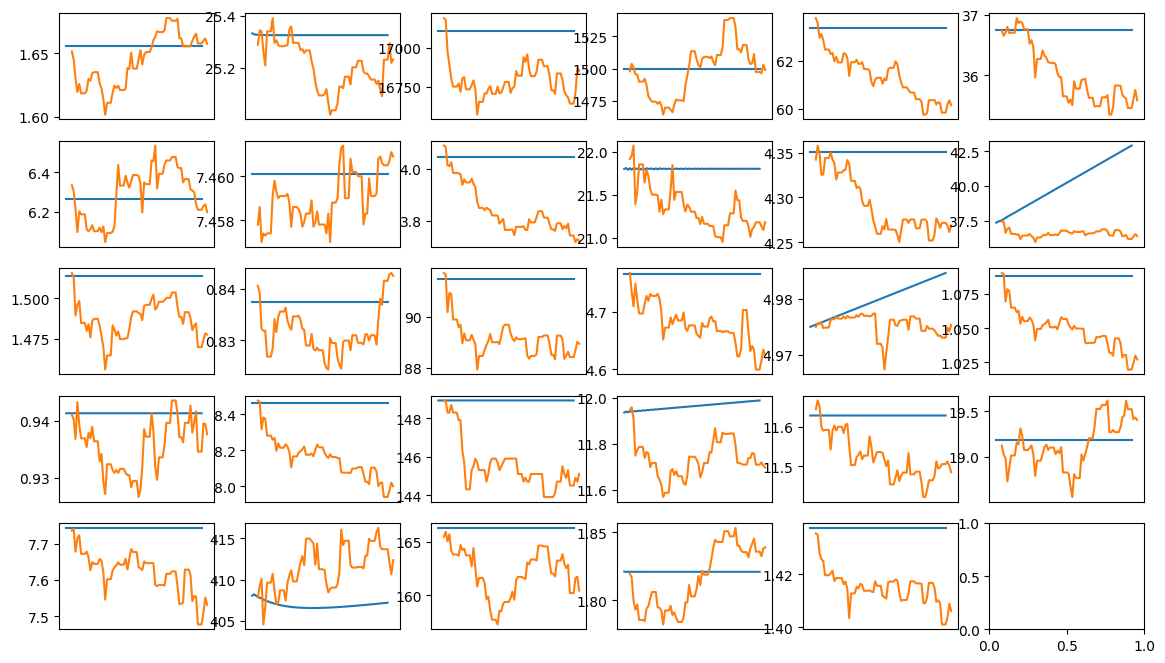

In [15]:
fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(14, 8))

for i, key in enumerate(preds):
  pred, target = preds[key]

  axs[i%5][int(i/5)].plot(pred)
  axs[i%5][int(i/5)].plot(target)

  axs[i%5][int(i/5)].tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False
  )

#### It doesn't even matter, if the model has decent R^2: it does not provide any insightful forecasts: it always returns zero

> A model, which I would love to try is Markov autoregression, however doesn't seem like, there are any decent implementation in Python, that would allow me to make forecasts using it

#### Since, statistical time-series models are not statisfactory: they either produce inconsistent or useless results in this case. (Markov autoregression is not implemented yet, ARCH may produce better results, but it does seem as if the time-series are variance-stationary)

## XGBoost

#### Now, I will move on to GBRT window-based model

In [16]:
# Because, we may experiment with different time windows for input and output, I will write a windowing function

def window_data(data: pd.DataFrame,
                input_lags: int,
                output_lags: int,
                feature_cols : list[str] | None = None) -> tuple[np.ndarray]:

  output = pd.DataFrame()
  feat_cols = []
  output_cols = []

  for i in range(1, input_lags+1):
    output[f'rate-{i}'] = data['rate'].shift(-i)
    feat_cols.append(f'rate-{i}')

  output['rate'] = data['rate']

  for j in range(1, output_lags+1):
    output[f'rate+{j}'] = data['rate'].shift(j)
    output_cols.append(f'rate+{j}')

  if feature_cols is not None:
    for col in feature_cols:
      output[col] = data[col]
      feat_cols.append(col)

  output.dropna(inplace=True)

  return output.loc[:, feat_cols].values, output.loc[:, output_cols].values

In [17]:
X, y = window_data(sample, 20, 7)

In [18]:
from sklearn.model_selection import RandomizedSearchCV

In [19]:
params = {
  'max_depth': np.arange(2, 10, step=4),
  'eta': np.logspace(-4, 0),
  'n_estimators': np.arange(3, 15, step=3)
}

In [20]:
def train_trees(df, 
                input_lags, 
                output_lags, 
                model,
                params):

  importances = {}
  models = {}
  scores = {}

  for group, data in df:
  # Use the data of a month, to forecast seven days into the future
    X, y = window_data(prepare_ts(data), input_lags, output_lags)

    rcv = RandomizedSearchCV(
      estimator = model,
      param_distributions= params,
      n_jobs=-1
    )

    rcv.fit(X, y)

    models[group] = rcv.best_estimator_
    scores[group] = rcv.best_score_
    importances[group] = rcv.best_estimator_.feature_importances_

  return importances, models, scores

In [21]:
model = xgboost.XGBRegressor()
importances, models, scores = train_trees(df, 30, 7, model, params)

#### Some scores are abismal, so we need to analyze and improve the model

<Axes: >

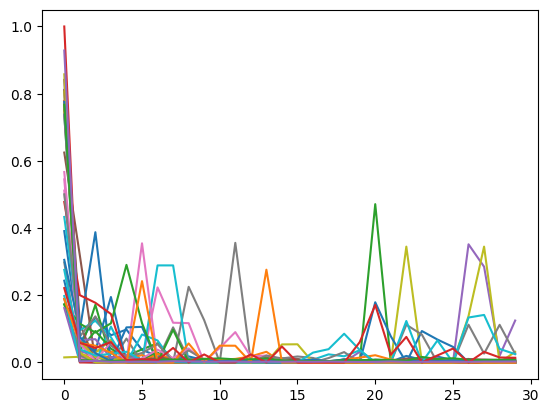

In [22]:
importances = pd.DataFrame(importances)
importances.plot(legend=False)

### It seems like, the most significant feature is the rate-1 (one day difference). However, for some, it is not the case. Maybe those indicate the failed currencies

In [23]:
mask = importances.apply(np.argmax) != 0
np.array(list(scores.values()))[mask]

array([ 8.39508263e-01,  6.42986896e-01,  4.20746332e-01,  3.42599522e-01,
        4.54475347e-01,  2.63520835e-01, -1.34968411e+00, -2.77037339e+02])

#### We can see, that it is not the problem, the number of features probably didn't cause such horrible performance

#### Let's take a sample model and look, at what are the tree parameters: maybe the lack of depth or estimators caused this bad performance

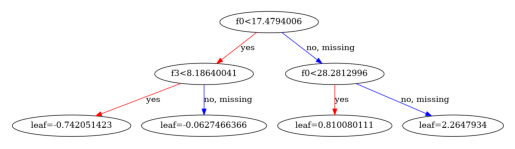

In [24]:
for j in filter(lambda key: scores[key] < -5, scores):
  xgboost.plot_tree(models[j])

#### While a lack of depth might explain the horrendous performance to some degree, deep trees may also produce horrible results in our case. However, we can try again and maybe make some marginal improvements before

In [25]:
params = {
  'n_estimators': np.arange(5, 15, step=5),
  'eta': np.logspace(-5, 0, num=5),
  'max_depth': np.arange(5, 20, step=5)
}

In [26]:
importances, models, scores = train_trees(df, 15, 7, model, params)

In [27]:
scores

{0: -3.9187727789637137,
 1: 0.7333068606693021,
 3: 0.9039738892723168,
 4: 0.8418599655646533,
 5: -3.11166640575237,
 6: 0.8455662600382832,
 7: 0.400724978063048,
 8: 0.7633493406617898,
 9: 0.35917559878656846,
 13: 0.4477295851429213,
 18: 0.7619740416351151,
 19: 0.626896466318851,
 20: 0.7342677937743999,
 21: -0.2844207112989884,
 22: 0.6290609638503903,
 23: 0.585086114558077,
 24: 0.5633271333185027,
 25: 0.14844215921013487,
 26: 0.2735174542021269,
 27: -0.17353346598124583,
 28: 0.8445962959622729,
 29: 0.73456723071833,
 30: 0.1330237569706923,
 31: 0.8145038757828711,
 32: 0.3627714898550327,
 33: 0.7147505208851312,
 34: -22.965102275591377,
 35: 0.7760385195434101,
 36: 0.0022321689039904056,
 37: 0.8165280218228543,
 38: 0.7514142159180585,
 39: -2.4471841374744434,
 40: 0.12013893358056937,
 41: 0.8233659322953212,
 42: 0.7134260170277045}

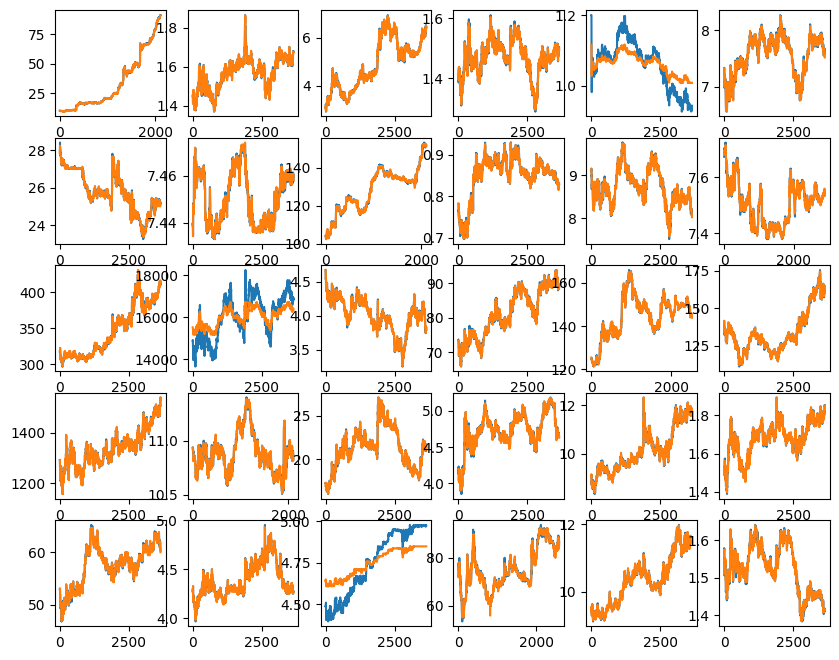

In [51]:
fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(10, 8))
for i, (curr, model) in enumerate(models.items()):
  data = df.get_group(curr)

  X, y = window_data(prepare_ts(data), 15, 7)
  pred = model.predict(X)

  pred_unw = [i[0] for i in pred]
  target_unw = [i[0] for i in y]

  try:
    axs[int(i/6)][i%6].plot(target_unw)
    axs[int(i/6)][i%6].plot(pred_unw)
  except IndexError:
    break

#### With the improvements of the parameter distribution, we obtain better R^2 metrics. However, we still have a problem with a few currencies.

Score for currency 5: -3.11166640575237


<Axes: >

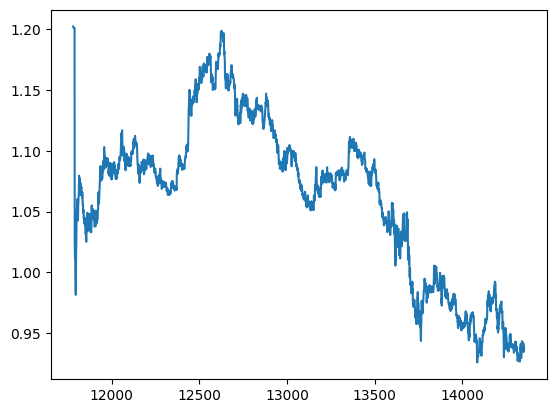

In [28]:
curr_gen = filter(lambda key: scores[key] < -2, scores)
next(curr_gen)
curr_id = next(curr_gen)

print(f"Score for currency {curr_id}: {scores[curr_id]}")
sample = df.get_group(curr_id)
sample.rate.plot()

#### The ones with a significant trend are the ones, that cause trouble, so we need to create a pipeline, that detrends the time-series, before it gets fit into the GBRT

In [29]:
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import StackingRegressor

In [30]:
estimators = [('ridge', Ridge())]
final_est = xgboost.XGBRegressor(max_depth=5, n_estimators=10)

model = MultiOutputRegressor(
  StackingRegressor(
    estimators=estimators,
    final_estimator=final_est
  ))

In [31]:
start = sample['time_period'].min()
sample['t'] = (sample['time_period'] - start)\
  .apply(lambda x: x.days)

/tmp/ipykernel_5295/3847029710.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['t'] = (sample['time_period'] - start)\


In [32]:
mask = sample['time_period'] < datetime(2024, 10, 1)

X_train, y_train = window_data(prepare_ts(sample[mask]), 10, 7, ['t'])
X_test, y_test = window_data(prepare_ts(sample[~mask]), 10, 7, ['t'])

In [33]:
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=StackingRegressor(estimators=[('ridge',
                                                              Ridge())],
                                                 final_estimator=XGBRegressor(base_score=None,
                                                                              booster=None,
                                                                              callbacks=None,
                                                                              colsample_bylevel=None,
                                                                              colsample_bynode=None,
                                                                              colsample_bytree=None,
                                                                              device=None,
                                                                              early_stopping_rounds=None,
                                                                              enable_categorical=False,
                                                                              eval_metric=None,
                                                                              feature_types=None,
                                                                              gamma=None,
                                                                              grow_policy=None,
                                                                              importance_type=None,
                                                                              interaction_constraints=None,
                                                                              learning_rate=None,
                                                                              max_bin=None,
                                                                              max_cat_threshold=None,
                                                                              max_cat_to_onehot=None,
                                                                              max_delta_step=None,
                                                                              max_depth=5,
                                                                              max_leaves=None,
                                                                              min_child_weight=None,
                                                                              missing=nan,
                                                                              monotone_constraints=None,
                                                                              multi_strategy=None,
                                                                              n_estimators=10,
                                                                              n_jobs=None,
                                                                              num_parallel_tree=None,
                                                                              random_state=None, ...)))

In [34]:
model.score(X_test, y_test)

-2.766770144829638

### Stacking regression does not solve the problem at all

In [35]:
from statsmodels.nonparametric.smoothers_lowess import lowess

### So the final regression strategy: LOWESS(locally-linear regression) for determining the deterministic part with XGBoost(gradient-boosted tree).

In [36]:
def score_rate_model(df):
  output = {
    "currency": [],
    "target": [],
    "prediction": [],
    "xgb_model": []
  }

  for group, data in df:
    output['currency'].append(group)

    data['t'] = (data['time_period'] - data['time_period'].min())\
      .map(lambda x: x.days)
    
    trend_y = lowess(data['t'], data['rate'], return_sorted=False)
    
    data['trend'] = trend_y
    data['rate'] = data['rate'] - data['trend']

    mask = data['time_period'] < datetime(2024, 11, 1)
    train, test = data[mask], data[~mask]

    model = xgboost.XGBRegressor()

    X, y = window_data(prepare_ts(train), 10, 7)
    X_test, y_test = window_data(prepare_ts(test), 10, 7)

    if y_test.shape[0] == 0:
      continue

    test = test.set_index('time_period').asfreq('d').bfill()
    cols = []
    for i in range(1, 8):
      test[f'trend+{i}'] = test['trend'].shift(i)
      cols.append(f'trend+{i}')
    for i in range(1, 11):
      test[f'trend-{i}'] = test['trend'].shift(-i)
    y_trend = test.dropna().loc[:, cols].values

    rcv = RandomizedSearchCV(
      model,
      param_distributions=params
    )
    rcv.fit(X, y)

    output['xgb_model'].append(rcv.best_estimator_)

    pred = rcv.best_estimator_.predict(X_test) + y_trend
    target = y_test + y_trend

    output['prediction'] = pred
    output['target'] = target

  return output

In [37]:
res = score_rate_model(df)

KeyboardInterrupt: 

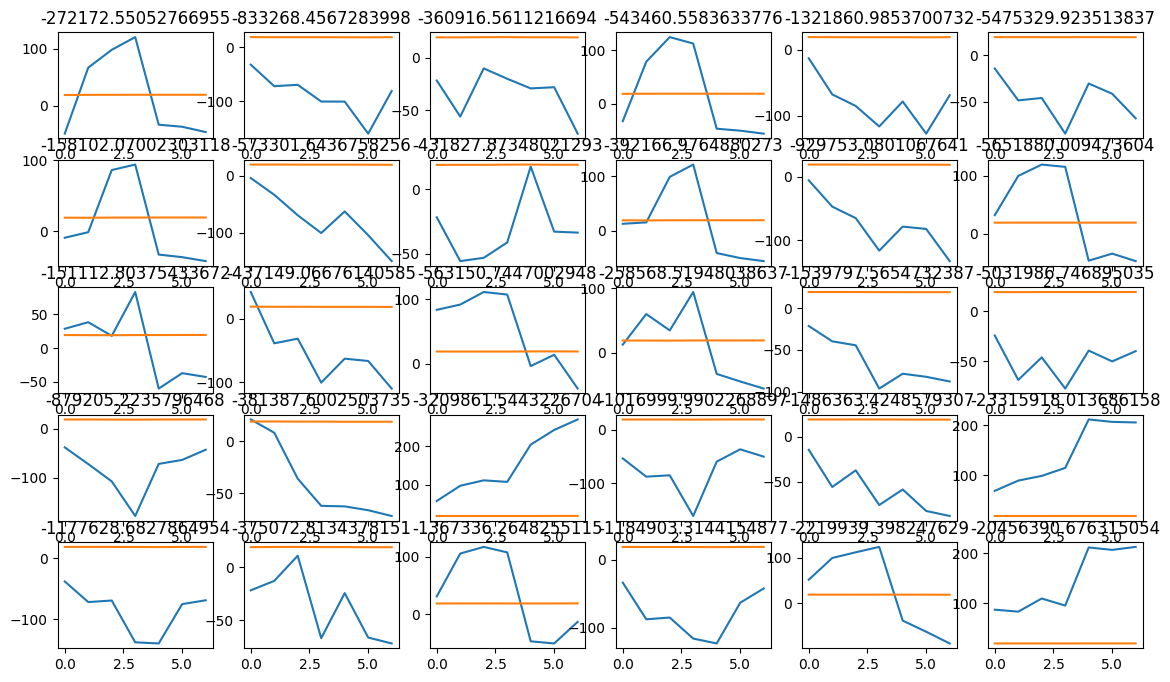

In [71]:
fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(14, 8))

for i, (pred, target) in enumerate(zip(res['prediction'], res['target'])):
  try:
    axs[i%5][int(i/5)].plot(pred)
    axs[i%5][int(i/5)].plot(target)

    r2 = r2_score(target, pred)
    axs[i%5][int(i/5)].set_title(r2)
  except:
    continue

### The results are absolutely horrible: the deternding strategy didn't work at all

## LSTM

#### First I will try to forecast a single currency with a trend

<Axes: >

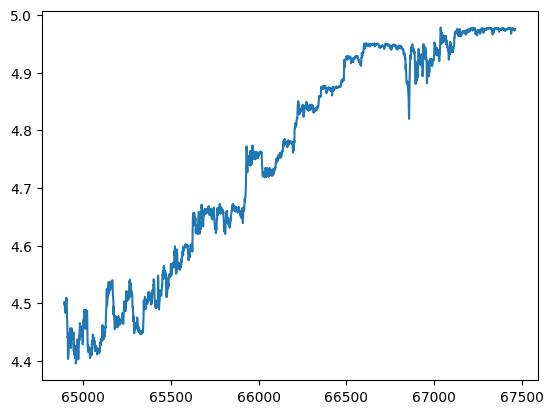

In [118]:
sample.rate.plot()

In [137]:
from torch.nn import Module, LSTM, Linear, MSELoss, ReLU
from torch import tensor, no_grad
from torch.optim import Adam

In [120]:
mask = sample['time_period'] < datetime(2024, 11, 1)

X_raw, y_raw = window_data(prepare_ts(sample[mask]), 14, 7, ['t'])
X_test_raw, y_test_raw = window_data(prepare_ts(sample[~mask]), 14, 7, ['t'])
X, y = tensor(X_raw), tensor(y_raw)
X_test, y_test = tensor(X_test_raw), tensor(y_test_raw)

print(X, y)

tensor([[   4.4833,    4.4833,    4.4833,  ...,    4.5023,    4.4892,
            7.0000],
        [   4.4833,    4.4833,    4.4880,  ...,    4.4892,    4.4744,
           10.0000],
        [   4.4833,    4.4880,    4.4928,  ...,    4.4744,    4.4744,
           10.0000],
        ...,
        [   4.9761,    4.9738,    4.9733,  ...,    4.9738,    4.9749,
         3574.0000],
        [   4.9738,    4.9733,    4.9728,  ...,    4.9749,    4.9747,
         3575.0000],
        [   4.9733,    4.9728,    4.9728,  ...,    4.9747,    4.9749,
         3576.0000]], dtype=torch.float64) tensor([[4.4878, 4.4978, 4.4990,  ..., 4.4975, 4.4975, 4.5020],
        [4.4892, 4.4878, 4.4978,  ..., 4.4975, 4.4975, 4.4975],
        [4.4833, 4.4892, 4.4878,  ..., 4.4990, 4.4975, 4.4975],
        ...,
        [4.9743, 4.9743, 4.9743,  ..., 4.9756, 4.9759, 4.9773],
        [4.9758, 4.9743, 4.9743,  ..., 4.9749, 4.9756, 4.9759],
        [4.9761, 4.9758, 4.9743,  ..., 4.9743, 4.9749, 4.9756]],
       dtype=torch.fl

In [168]:
class LSTMForecast(Module):

  def __init__(self, input_dim, hidden_dim, output_dim, *args, **kwargs):
    super().__init__(*args, **kwargs)

    self.input_dim = input_dim
    self.output_dim = output_dim

    self.activation = ReLU()

    self.linear = Linear(in_features=hidden_dim,
                         out_features=output_dim)

    self.lstm = LSTM(input_size=input_dim,
                     hidden_size=hidden_dim)

  def forward(self, X):
    lstm_out, _ = self.lstm(X.view(1, -1))
    lstm_out = self.activation(lstm_out)

    lin_out = self.linear(lstm_out.view(-1))

    return lin_out

In [180]:
model = LSTMForecast(15, 8, 7)
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

for epoch in range(10):
  for x, target in zip(X, y):
    
    pred = model(x.float())

    loss = loss_function(pred, target.float())
    loss.backward()
    optimizer.step()

    r2 = r2_score(pred.detach().numpy(), target.detach().numpy())

  print(f"Loss at epoch {epoch}: {loss.item()}, r^2: {r2}")

Loss at epoch 0: 0.5758655667304993, r^2: -0.0028703243939744993
Loss at epoch 1: 1.5047433376312256, r^2: -2.0542872164671366
Loss at epoch 2: 0.423862487077713, r^2: -0.11247871205898274
Loss at epoch 3: 0.2683507800102234, r^2: -0.01032184310731532
Loss at epoch 4: 0.27672919631004333, r^2: -0.3871318813534568
Loss at epoch 5: 0.09219815582036972, r^2: -0.5366871522577465
Loss at epoch 6: 0.07843952625989914, r^2: -0.5151013586628495
Loss at epoch 7: 0.04928134009242058, r^2: -0.6359612681529354
Loss at epoch 8: 0.0096952049061656, r^2: -0.014312719117821393
Loss at epoch 9: 0.03848234936594963, r^2: -1.5965167905145332


-5488.4804054812375


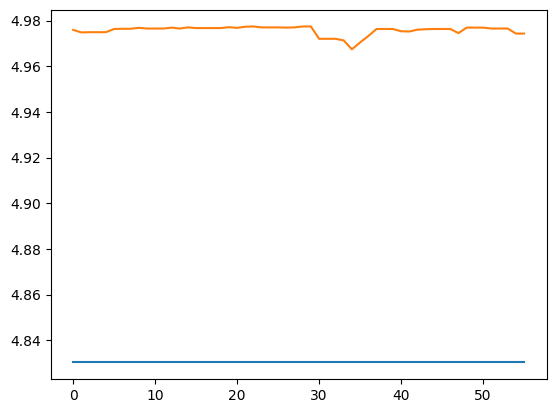

In [183]:
pred = [model(x.float()).detach().numpy()[0] for x in X_test]
target = [t[0] for t in y_test]

plt.plot(pred)
plt.plot(target)

print(r2_score(target, pred))

#### LSTMS don't seem to solve the issue of time-series with a trend, so the final model, that will be used here is XGBoost

## Multivariate modelling with XGBoost

In [4]:
df = master[(master['bop_measure'] == 3) & 
            (master['inr_measure'] == 3)]\
            .drop(['bop_measure', 'inr_measure'], axis='columns')\
            .rename(columns={'date': 'time_period'})\
            .groupby('currency')

NameError: name 'master' is not defined

In [55]:
def train_multivar_trees(
  df, 
  input_lags, 
  output_lags, 
  params,
  with_macro = False):

  importances = {}
  models = {}
  scores = {}

  for group, data in df:
  # Use the data of a month, to forecast seven days into the future
    if with_macro:
      X, y = window_data(prepare_ts(data), input_lags, output_lags, ['bop_value', 'inr_value'])
    else:
      X, y = window_data(prepare_ts(data), input_lags, output_lags)
    model = xgboost.XGBRegressor()

    rcv = RandomizedSearchCV(
      estimator = model,
      param_distributions= params,
      n_jobs=-1
    )

    rcv.fit(X, y)

    models[group] = rcv.best_estimator_
    scores[group] = rcv.best_score_
    importances[group] = rcv.best_estimator_.feature_importances_

  return importances, models, scores

In [56]:
params = {
  'n_estimators': np.arange(5, 15, step=5),
  'eta': np.logspace(-5, 0, num=5),
  'max_depth': np.arange(5, 20, step=5)
}

res = train_multivar_trees(df, 14, 7, params, with_macro=False)

In [57]:
importances, models, scores = res
scores

{1: 0.8064830867367654,
 4: 0.8830728233819538,
 5: -3.376843077951812,
 6: 0.8489404410462609,
 7: 0.42688248865005507,
 8: 0.7683147668411179,
 13: 0.3724245861687601,
 20: 0.7581665505971324,
 23: 0.8397055083266649,
 24: 0.558314892294488,
 25: 0.19266994116660746,
 30: 0.6783598761610807,
 31: 0.855024809451401,
 33: 0.8127181378380353,
 36: -0.4091145999323892,
 41: 0.809081313220207,
 42: 0.7868966658114281}

In [58]:
res = train_multivar_trees(df, 14, 7, params, with_macro=True)

In [59]:
importances, models, scores = res
scores

{1: 0.6086104006870529,
 4: 0.7693361348753134,
 5: 0.26619231236695085,
 6: 0.7827398520448092,
 7: -4.121506584476739,
 8: 0.5304062679764528,
 13: 0.16902370713200526,
 20: 0.6665851774968903,
 23: 0.7747361515556381,
 24: 0.4607005763774234,
 25: 0.1377992315922632,
 30: 0.6113532879987227,
 31: 0.8037611401265796,
 33: 0.716367251958172,
 36: -0.39720736816498736,
 41: 0.6848116929690455,
 42: 0.588740633495836}

### Because $R^2$ actualy decreased, I will only use a univariate model